# Econometria Aplicada

## REGRESSÃO LINEAR SIMPLES



João Ricardo Costa Filho \\
[joaocostafilho.com](https://)

O exercício quantitativo desta aula é baseado em [Gravity in R: a short workshop](https://imedkrisna.github.io/gravity/).

## A regressão linear

**Motivação**: \\

Como a distância entre países afeta as trocas comerciais entre eles?

### Dados

Vamos utilizar os seguintes conjuntos de dados:

* Gravity: "Data to estimate gravity equations: trade, GDP, population, trade agreements, etc. For all country pairs, 1948-2020."

Eles estão disponíveis neste [link](https://www.cepii.fr/CEPII/en/bdd_modele/bdd_modele.asp). Iremos baixar a versão para o R:

In [ ]:
url      <- "https://www.cepii.fr/DATA_DOWNLOAD/gravity/legacy/202202/Gravity_rds_V202202.zip"

In [ ]:
destfile <- "Gravity_rds_V202202.zip"

In [ ]:
download.file( url, destfile, mode = "wb")

In [ ]:
unzip( destfile )

Podemos verificar no diretório no qual estamos trabalhando que os dados foram baixados. Para isso, clique na 'pasta' no menu vertical que está à esquerda.

Façamos o upload da base de dados:

In [ ]:
gravity <- readRDS("Gravity_V202202.rds")

Para selecionarmos as primeiras 10 linhas de um 'dataframe', podemos utilizar o seguinte comando:

In [ ]:
head( gravity, 10)

Quando tivermos dúvida sobre uma função, podemos utilizar "?":

In [ ]:
?head

Para visualizarmos as últimas 4 linhas, podemos utilizar o seguinte comando:

In [ ]:
tail( gravity, 4 )

E a estrutura dos dados do 'dataframe' pode ser obtida da seguinte forma:

In [ ]:
str( gravity ) # estrutura dos dados

Podemos encontrar a definição das variáveis [aqui](https://www.cepii.fr/DATA_DOWNLOAD/gravity/legacy/2015/gravdata_codebook_2015.pdf#page=9.30) e [aqui](https://www.cepii.fr/DATA_DOWNLOAD/gravity/doc/Gravity_documentation.pdf#page=39.80).

## Tratamento da base de dados para a regressão

---



Utilizaremos o pacote 'dplyr' para manipulação dos dados:

In [ ]:
library(dplyr)

Faremos alguns filtros. O primeiro, diz respeito ao ano dos dados. Trabalhemos com 2019, antes da pandemia. Depois, filtraremos os códigos dos páises de origem e de destino, respectivamente. Finalmente, excluíremos dos dados referentes à situação na qual o país de origem e destino é o mesmo:

In [ ]:
gravity2 <- gravity %>% filter( year == 2019 ) %>%
            filter( country_id_o!="IDN.1" )    %>%
            filter( country_id_d!="IDN.1" )    %>%
            filter( iso3_o!=iso3_d )

## Visualização dos dados

Faça um histograma da variável 'tradeflow_baci' (que mede os fluxos comerciais bilaterais entre os países):

In [ ]:
hist( gravity2$tradeflow_baci )

Um opção seria tentar melhorar a visualização do gráfico anterior. Alternativamente, podemos crie uma variável com a função 'log' que calcula o logaritmo natural do fluxo comercial bilateral (se tiver dúvida sobre ela, utlize o comando '?'):

Agora, faça um histograma da variável que você criou:

Podemos salvar o gráfico em pdf:

In [ ]:
pdf('tradeflow.pdf')
hist( lntrade )
dev.off()

Podemos melhorar a estética dos gráficos um pouco mais com o pacote 'ggplot2':

In [ ]:
library(ggplot2)

Voltando ao nosso gráfico:

In [ ]:
ggplot( gravity2 ) +
  geom_histogram(aes(x = log( tradeflow_baci ), y = ..density..), color = "black", fill = "darkred", alpha = 0.8) +
    labs(title = "Histograma do ln dos fluxos comerciais", x = NULL, y = "Densidade") +
  theme_classic()

Podemos editar o tamanho e a fonte do título e dos eixos:

In [ ]:
 ggplot( gravity2 ) +
  geom_histogram(aes(x = log( tradeflow_baci ), y = ..density..), color = "black", fill = "darkred", alpha = 0.8) +
    labs(title = "Histograma do ln dos fluxos comerciais", x = NULL, y = "Densidade") +
  theme_classic() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 12),
    strip.text = element_text(size = 12, face = "bold")
  )

Façamos a dispersão entre o ln dos fluxos comerciais e o ln da distância entre os países:

In [ ]:
ggplot( gravity2, aes( x = log( distw_harmonic ), y = log( tradeflow_baci ) ) ) +
  geom_point( color = 'darkred', size = 3 ) +
  labs(title = "Fluxos comerciais vs distância",
       x = "Distância",
       y = "Fluxos comerciais") +
         theme_classic() +
  theme(plot.title = element_text(size = 16, face = "bold"),
        axis.title.x = element_text(size = 14, face = "bold"),
        axis.title.y = element_text(size = 14, face = "bold")
        ) +
  theme(panel.background = element_rect(fill = "#f0f0f0"),
        plot.background = element_rect(fill = "#f0f0f0"),
        panel.grid.major = element_line(colour = "white") )

Estatísticas descritivas

In [ ]:
summary(gravity2[, c("distw_harmonic", "tradeflow_baci" )])

## Tratamento da base de dados para a regressão

---



Para utilizarmos o dataframe 'gravity2' nas nossas regressões, é importante criarmos dentro dele todas as variáveis que desejamos utilizar no exercício econométrico. Ainda que a nossa pergunta tenhamos a necessidade apenas de duas variáveis, criemos outras que serão utilizadas oportunamente:

In [ ]:
gravity2 <- gravity2 %>% mutate( lndist    = log( distw_harmonic ),      # Distância (média harmônica)
                                 lngdpo    = log( gdp_o ),               # PIB do país de origem
                                 lngdpd    = log( gdp_d ),               # PIB do país de destino
                                 lngdpco   = log( gdpcap_o ),            # PIB per capita do país de origem
                                 lngdpcd   = log( gdpcap_d ),            # PIB per capita do país de destino
                                 lntrade = log( 1 + tradeflow_baci )     # Fluxo de comércio entre dois países
                                 )

## Regressão

Estime a seguinte regressão: \\
\
$\ln T_{i,j} = \beta_0 + \beta_1 \ln Dist_{i,j} + ɛ_i$


In [ ]:
reg <- lm( lntrade ~ lndist, data=gravity2 )

In [ ]:
summary( reg )

Podemos atualizar a dispersão com ela:

In [ ]:
ggplot( gravity2, aes( x = log( distw_harmonic ), y = log( tradeflow_baci ) ) ) +
  geom_point( color = 'darkred', size = 3 ) +
  labs(title = "Fluxos comerciais vs distância",
       x = "Distância",
       y = "Fluxos comerciais") +
         theme_classic() +
  theme(plot.title = element_text(size = 18, face = "bold"),
        axis.title.x = element_text(size = 14, face = "bold"),
        axis.title.y = element_text(size = 14, face = "bold")
        ) +
  theme(panel.background = element_rect(fill = "#f0f0f0"),
        plot.background = element_rect(fill = "#f0f0f0"),
        panel.grid.major = element_line(colour = "white") )+
     geom_smooth(method = lm, se = FALSE, fullrange = TRUE)


Qual é o valor do fluxo comercial esperado para dois países que estão a 12.967 km de distância?

Essas é a distância entre o Brasil e Samoa Americana. Podemos verificar os dados e ver como a nossa regressão se saiu:

In [ ]:
gravity2 %>% filter( iso3_o=="BRA" & iso3_d=="ASM" ) %>% select( iso3_d, tradeflow_baci, distw_harmonic  )

Faça a mesma análise para o comércio entre Brasil e Argentina (que estão à 1.997 km de distância):

## Inferência

Como verificar se a associação entre as variáveis é estatísticamente significativa? Realizados testes de hipótese!

Para $\hat{ \beta}_0$:

$\mathcal{H}_0: \beta_0 = 0$ \\
$\mathcal{H}_a: \beta_0 \neq 0$ \\

Para $\hat{ \beta}_1$:

$\mathcal{H}_0: \beta_1 = 0$ \\
$\mathcal{H}_a: \beta_1 \neq 0$ \\

Vamos simular os dados:

In [ ]:
# Para replicarmos as variáveis pseudo aleatórias
set.seed(1301)

# Definindo os parâmetros

amostras <- 500 # número de amostras

n <- 200        # tamanho de cada amostra

b0 <- 2

b1 <- 3

# Criando as amostras

X <- replicate( amostras, rnorm( n, mean = 10, sd = 2 ) )

print( "Variável X: linhas e colunas")

nrow( X ) # numero de linhas
ncol( X ) # número de colunas

e <- replicate( amostras, rnorm( n, mean = 0, sd = 1 ) )

Y <- b0 + b1 * X + e

print( "Variável Y: linhas e colunas")

nrow( Y ) # numero de linhas
ncol( Y ) # número de colunas

[1] "Variável X: linhas e colunas"


[1] 200

[1] 500

[1] "Variável Y: linhas e colunas"


[1] 200

[1] 500

In [ ]:
# Fazendo as regressões

regressoes <- lapply( 1:amostras,
                      function(i) lm( Y[ , i ] ~ X[ , i ] ) )

betas <- sapply(regressoes, function(modelo) coef(modelo)[2])

beta1 = mean( betas )

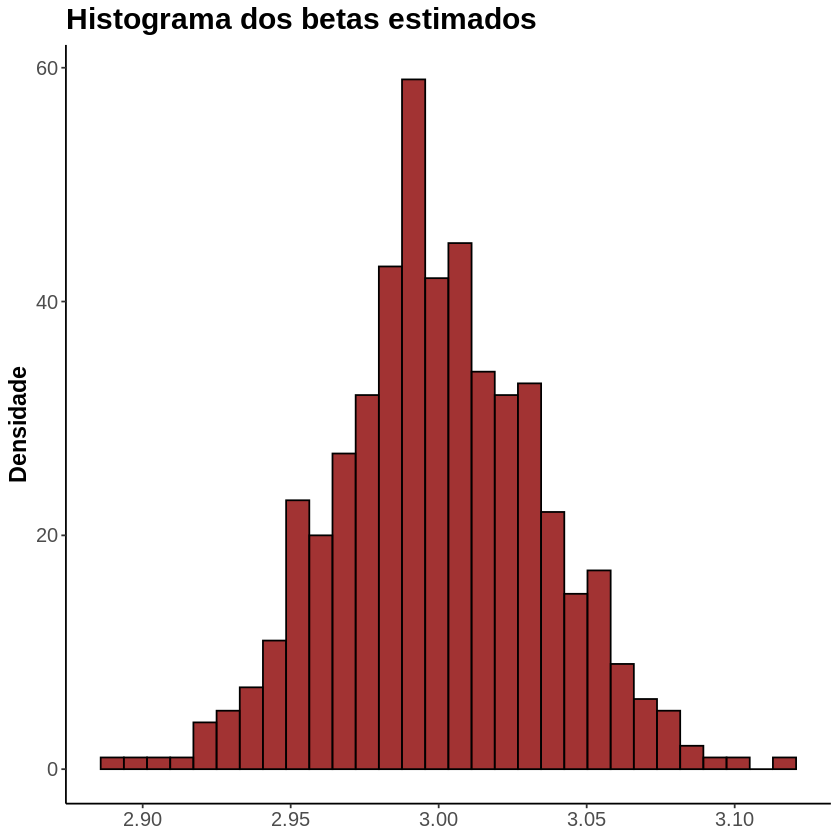

In [ ]:
# Gráfico dos betas
ggplot() +
  geom_histogram( aes(x = betas), bins = 30, color = "black", fill = "darkred", alpha = 0.8) +
  labs(title = "Histograma dos betas estimados", x = NULL, y = "Densidade") +
  theme_classic() +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 12),
    strip.text = element_text(size = 12, face = "bold")
  )

E se aumentarmos o tamanho da amostra para 2000 elementos em cada uma das 500 amostras?

In [ ]:
# Para replicarmos as variáveis pseudo aleatórias
set.seed(13)

# Definindo os parâmetros

amostras <- 500 # número de amostras

n <- 2000        # tamanho de cada amostra

b0 <- 2

b1 <- 3

# Criando as amostras

X <- replicate( amostras, rnorm( n, mean = 10, sd = 2 ) )

e <- replicate( amostras, rnorm( n, mean = 0, sd = 1 ) )

Y <- b0 + b1 * X + e

In [ ]:
# Fazendo as regressões

regressoes <- lapply( 1:amostras,
                      function(i) lm( Y[ , i ] ~ X[ , i ] ) )

betas <- sapply(regressoes, function(modelo) coef(modelo)[2])

beta1 = mean( betas )

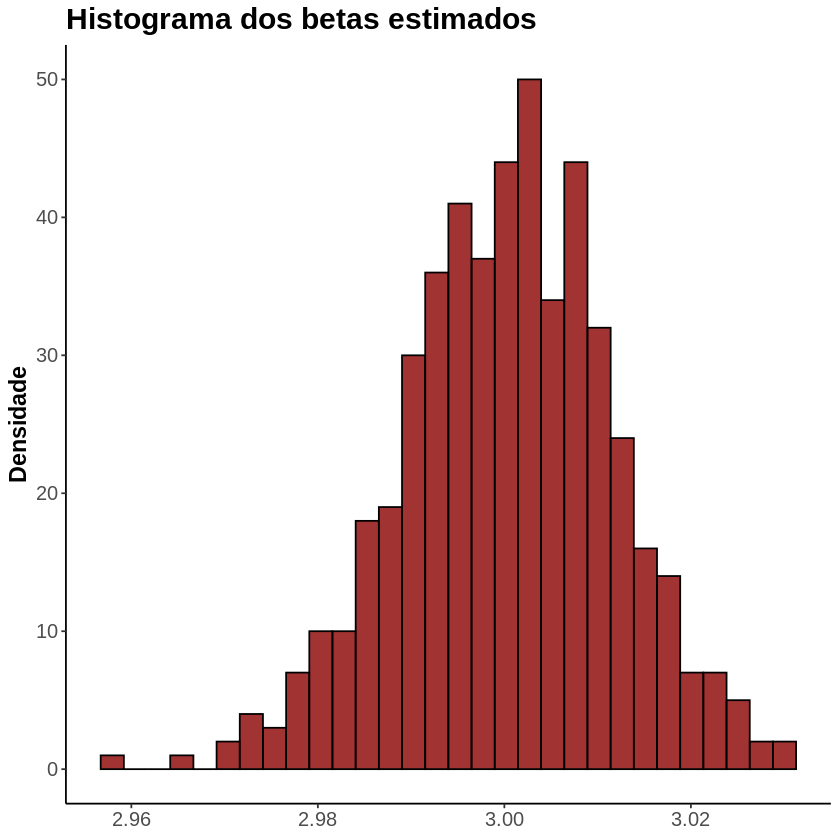

In [ ]:
# Gráfico dos betas
ggplot() +
  geom_histogram( aes(x = betas), bins = 30, color = "black", fill = "darkred", alpha = 0.8) +
  labs(title = "Histograma dos betas estimados", x = NULL, y = "Densidade") +
  theme_classic() +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 12),
    strip.text = element_text(size = 12, face = "bold")
  )

Note que a variabilidade diminuiu!

Vamos verificar a consistência do estimador:

In [ ]:
tamanhos = c( seq( from = 5, to = 90, by = 5 ),  seq( from = 100, to = 10000, by = 500 ) )

amostras = length( tamanhos ) # número de amostras

beta_mean = rep( NA, amostras )

for ( n in 1:amostras ) {

  set.seed( 13 + n )

  b0 <- 2

  b1 <- 3

  # Criando as amostras

  X <- replicate( amostras, rnorm( tamanhos[ n ], mean = 10, sd = 2 ) )

  e <- replicate( amostras, rnorm( tamanhos[ n ], mean = 0, sd = 1 ) )

  Y <- b0 + b1 * X + e

  regressoes <- lapply( 1:amostras,
                        function(i) lm( Y[ , i ] ~ X[ , i ] ) )

  betas <- sapply(regressoes, function(modelo) coef(modelo)[2])

  beta_mean[ n ] = mean( betas ) - b1


}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


NULL

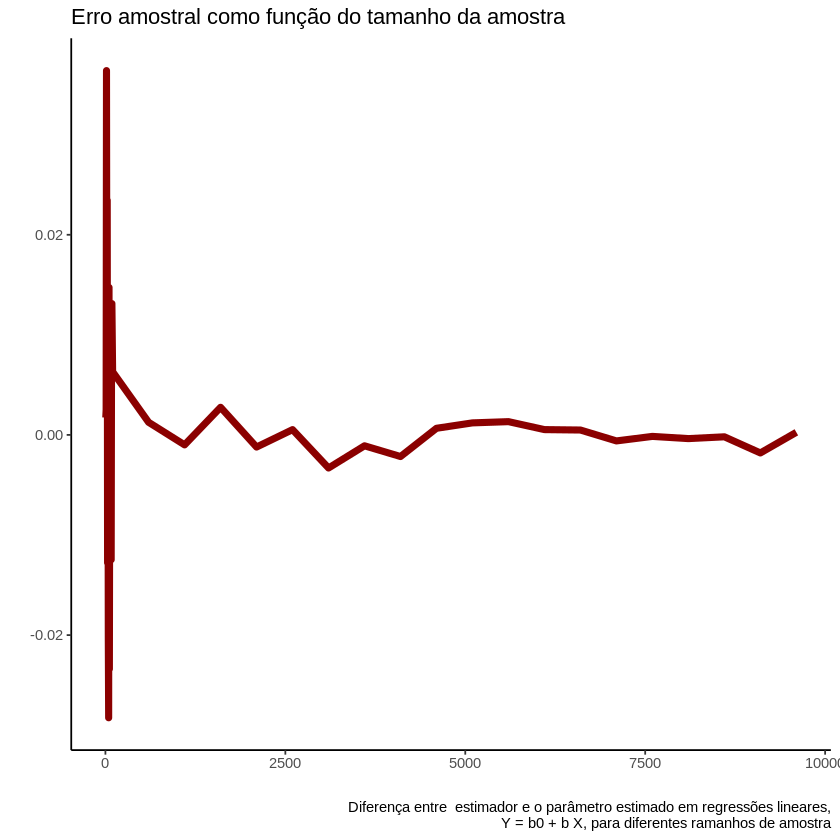

In [ ]:
data = data.frame( beta_mean, tamanhos  )

ggplot(data) +
  geom_line( aes(x = tamanhos, y = beta_mean), colour = "darkred", size = 2) +
  theme_classic() +
  labs(   title = "Erro amostral como função do tamanho da amostra",
              x = "",
              y = "",
        caption = "Diferença entre  estimador e o parâmetro estimado em regressões lineares,
                         Y = b0 + b X, para diferentes ramanhos de amostra" )

                           labs(, x = NULL, y = "Densidade") +
  theme_classic() +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 18),
    strip.text = element_text(size = 14, face = "bold") )

## Desafio para casa

Como podemos fazer para estimar a equação abaixo? \\

$T_{o,d} = \frac{ Y_o \times Y_d }{ D_{o,d} }$ \\

onde $T_{i,j}$ representa o fluxo comercial bilateral entre o país de origem ($o$) e o país de destino ($d$), $Y_o$ é o PIB do país de origem, $Y_d$ é o PIB do país de destino e $D_{o,d}$ a distância entre eles.



O que eu espero dos coeficientes da regressão?